In [78]:
from os.path import abspath
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inspect

In [79]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [80]:
# create database
# File location and type
file_location_array = [
    {"location" : "../../training/pred_tremi_full.csv", "name": "pred_tremi_full", "delimiter": ","},
    {"location" :  "../../training/training_dpe.csv", "name": "training_dpe", "delimiter": ","},
    {"location" :  "../../training/prediction_dpe.csv", "name": "prediction_dpe", "delimiter": ","},
    {"location" :  "../../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type) \
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )
    dataframes[file["name"]].show()

+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|gender|age|occupation|home_state|nb_persons_home|income|population|n_development_licence|n_construction_licence|n_new_buildings|n_destruction_licence|department_number|surface|heating_production|heating_emission|
+------+---+----------+----------+---------------+------+----------+---------------------+----------------------+---------------+---------------------+-----------------+-------+------------------+----------------+
|     0| 39|        13|         0|              3|     4|     12368|                    4|                    41|             43|                    0|               50|   null|              null|            null|
|     1| 26|        14|         0|              1|     1|    115934|                    5|                    78|            702|               

In [81]:
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface' : F.col('surface').cast('float'),
        'heating_production' : F.col('heating_production').cast('int'),
        'heating_emission' : F.col('heating_emission').cast('int')
    })
)

dictionary = dataframes['dictionary']

In [82]:

training_surf = training_tremi.filter(F.col('surface').isNotNull()).drop('heating_emission', 'heating_production')
predicting_surf = training_tremi.filter(F.col('surface').isNull()).drop('heating_emission', 'heating_production')

training_prod = training_tremi.filter(F.col('heating_production').isNotNull()).drop('heating_emission', 'surface')
predicting_prod = training_tremi.filter(F.col('heating_production').isNull()).drop('heating_emission', 'surface')

training_em = training_tremi.filter(F.col('heating_emission').isNotNull()).drop('surface', 'heating_production')
predicting_em = training_tremi.filter(F.col('heating_emission').isNull()).drop('surface', 'heating_production')

print(training_surf.count(), predicting_surf.count(), training_prod.count(), predicting_prod.count(), training_em.count(), predicting_em.count())

12565 26933 11128 28370 12558 26940


In [83]:
# get the name of  variable outside fonction
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# cut variable name if too long
def cut(name):
    if isinstance(name, str) and len(name)>10:
        return name[0:10]
    return name

# get all values in dict form
def get_dict(df):
    col_names = [col[0] for col in df.dtypes]
    values = {}
    rows = df.collect()
    for col_name in col_names:
        values[col_name] = [cut(row[col_name]) for row in rows]
    return values

# get labels for a variable thanks to dictionary
def get_labels(variable):
    study = (
        dictionary.filter(
            F.col('column') == variable
        )
        .select(
            F.col('value'),
            F.col('meaning')
        )
        .dropDuplicates()
        .orderBy('value')
    )
    return get_dict(study)

# return ticks for pie
def get_percent(value, values):
    total = sum(values)
    if len(values) < 5:
        return f'{value/100*total:.0f}\n{value:.2f}%'
    else:
        return f'{value:.1f}'

# plot pie
def plot_repartition(df, variable, ax, title=None):
    labels = get_labels(variable)['meaning']
    count = get_dict(df.groupBy(variable).count().orderBy(variable))['count']
    ax.pie(count, labels = labels, autopct=lambda x: get_percent(x,count),startangle=90)
    if title:
        ax.set_title(title)

# plot_hist
def plot_hist(df, variable, ax, title=None):
    
    labels = get_labels(variable)['meaning']
    values = get_dict(df.groupBy(variable).count().orderBy(variable))
    total = sum(values['count'])
    percent = [value * 100 / total for value in values['count']]
    x = values[variable]
    min_value = int(min(values[variable]))

    # bar graph
    bars = ax.bar(x=x, height = percent, width=0.5)
    ax.set_xticks(range(min_value, len(labels) + min_value), labels, rotation = 90)

    # set y ticks
    vals = ax.get_yticks()
    ax.set_yticklabels(['%1.2f%%' %i for i in vals])

    # plot percentage
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.1f}%",(bar.get_x() + bar.get_width()/2, height+.05),ha="center",va="bottom",fontsize=10)

    # title
    if title:
        ax.set_title(title)

# plot multiple chart
def compare_repartition(dfs, variable):
    f, ax = plt.subplots(1, len(dfs), figsize=(20,5), sharey=True)
    plt.subplots_adjust(wspace=0.2)
    if len(dfs) > 1:
        for i, df in enumerate(dfs):
            plot_hist(df, variable, ax[i], retrieve_name(df))
    else:
        plot_hist(dfs[0], variable, ax, retrieve_name(dfs[0]))

# input variables

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_23440\4174029921.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


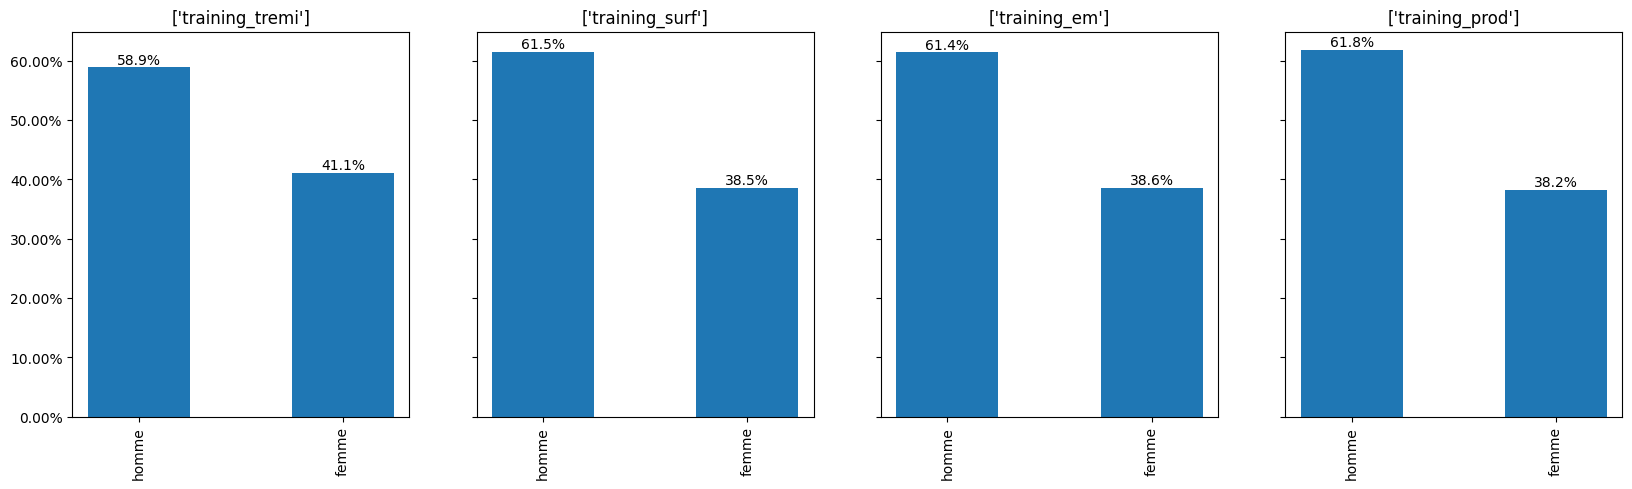

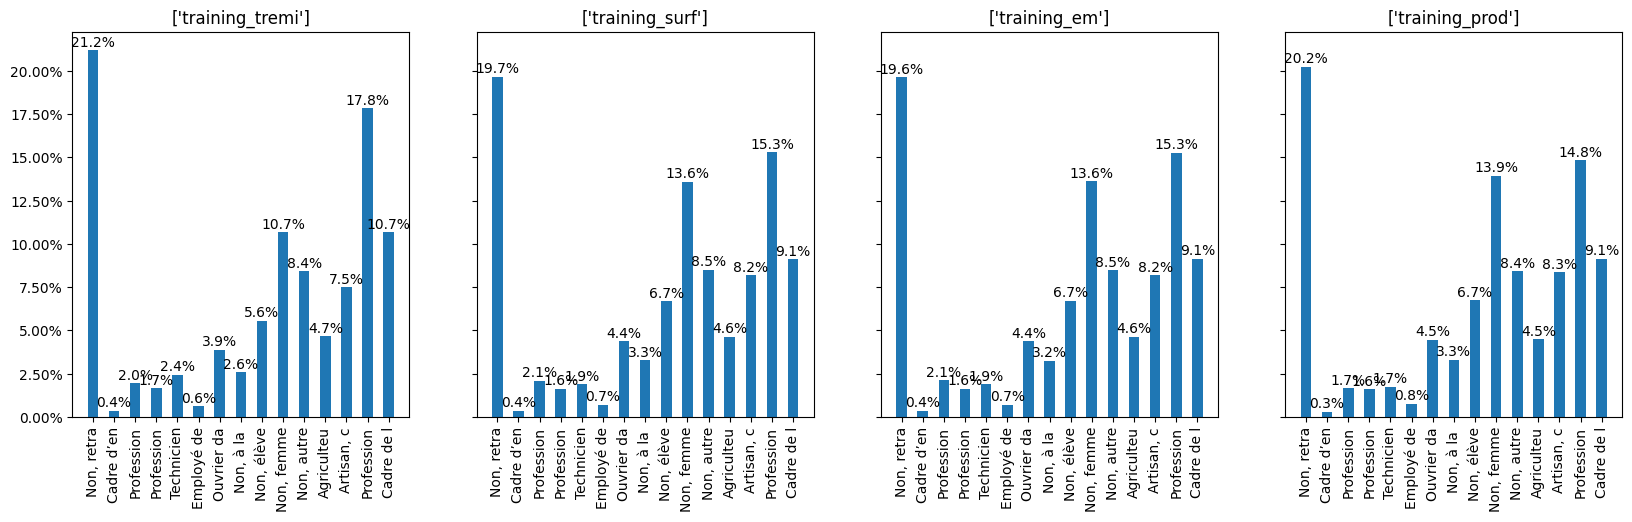

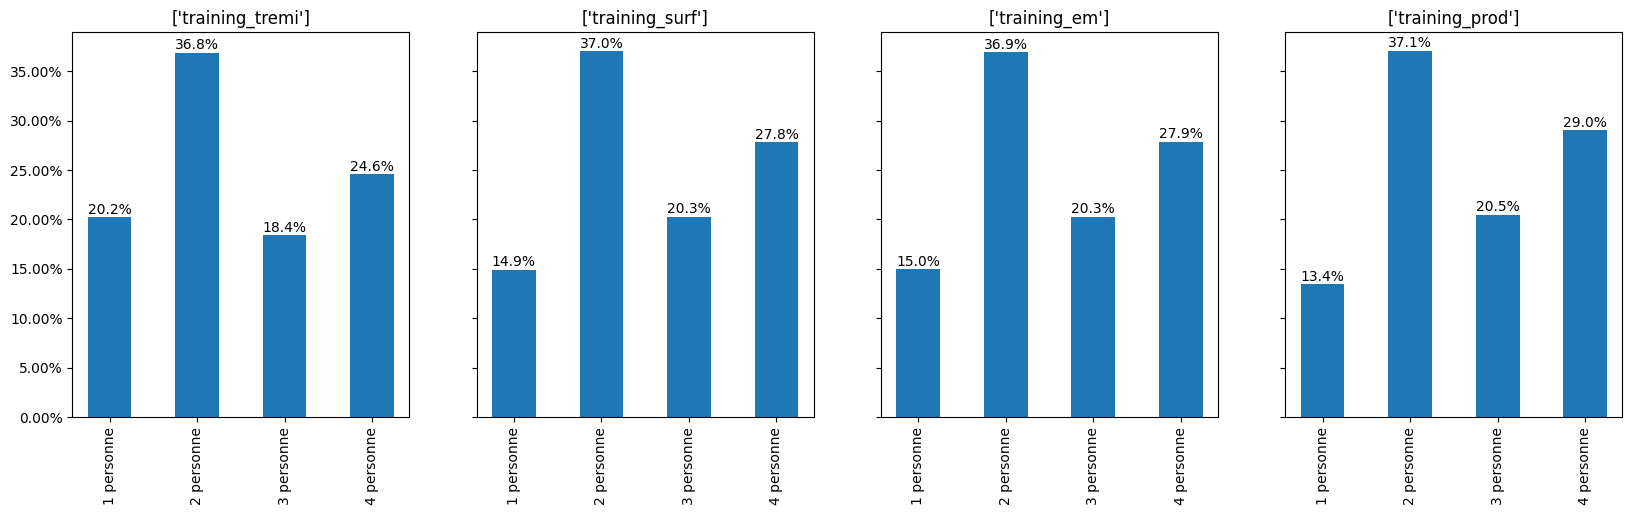

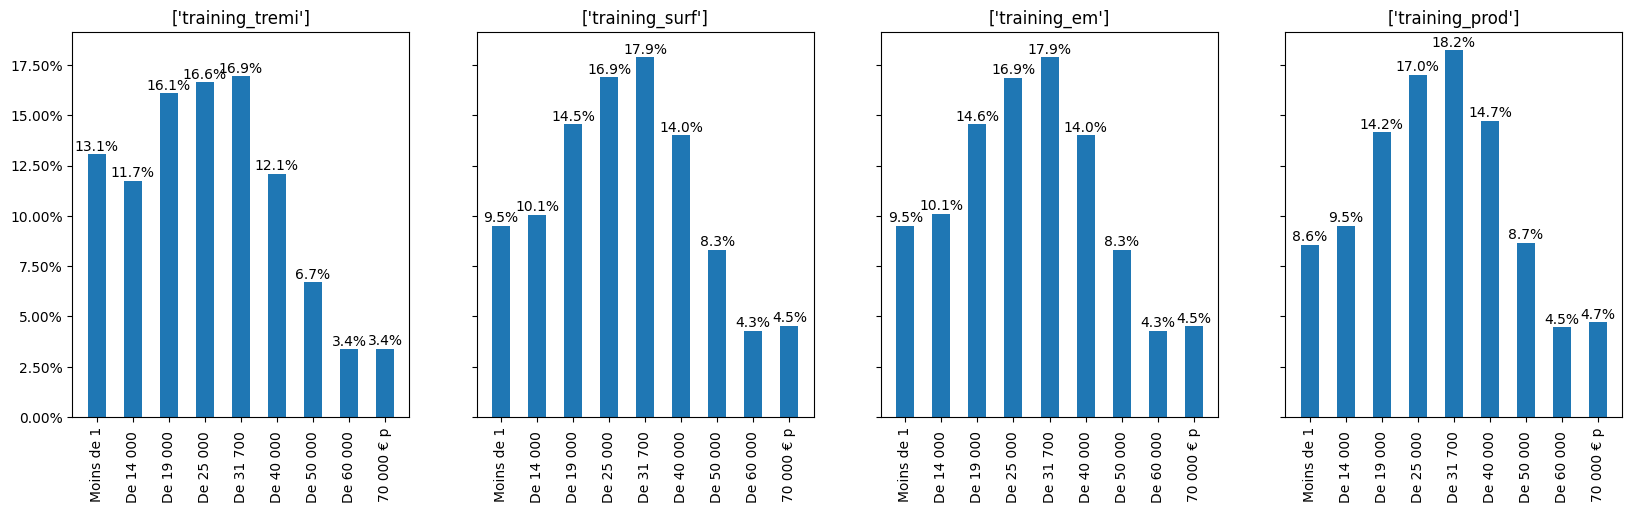

In [84]:
dfs = [training_tremi, training_surf, training_em, training_prod]
compare_repartition(dfs, 'gender')
compare_repartition(dfs, 'occupation')
compare_repartition(dfs, 'nb_persons_home')
compare_repartition(dfs, 'income')

In [85]:
def histo(df, variable, bins = 20):
    plt.title(variable)
    plt.hist(df.select(variable).toPandas(), bins=bins)
    plt.show()

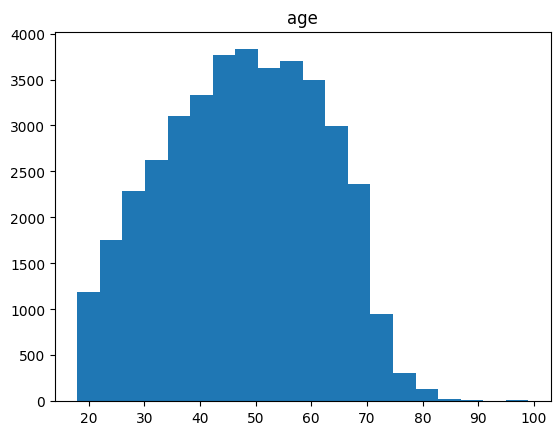

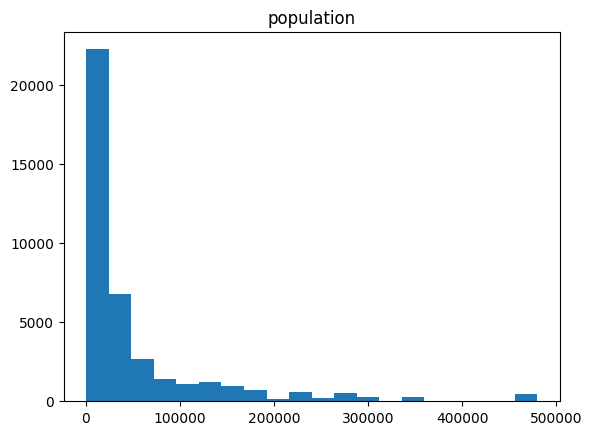

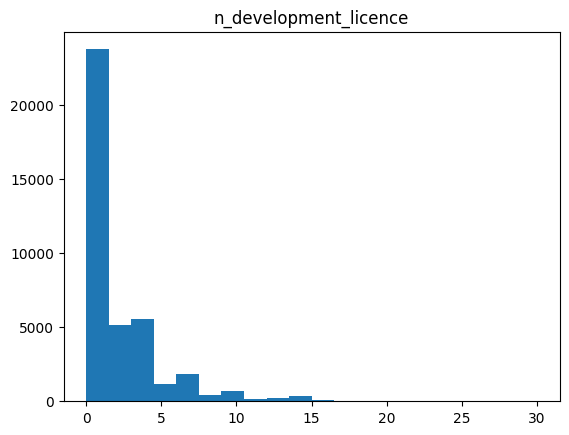

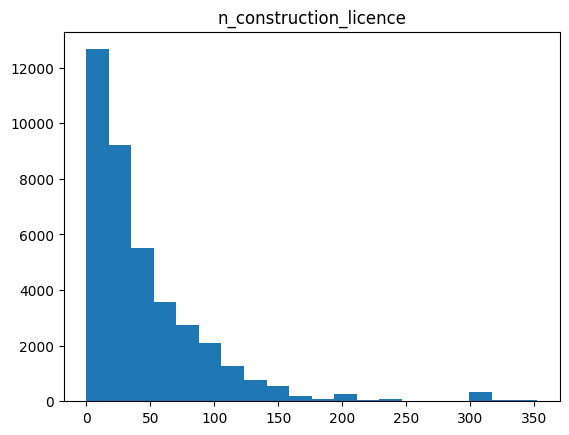

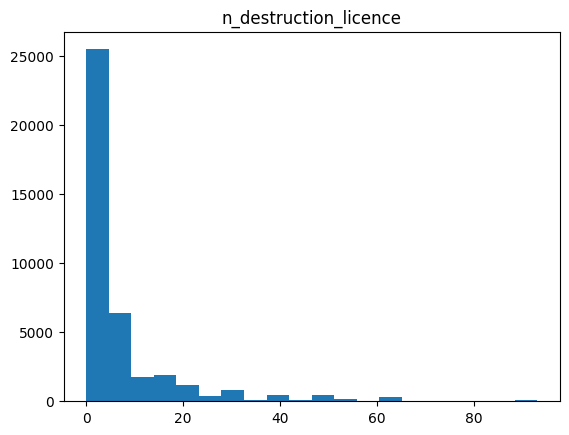

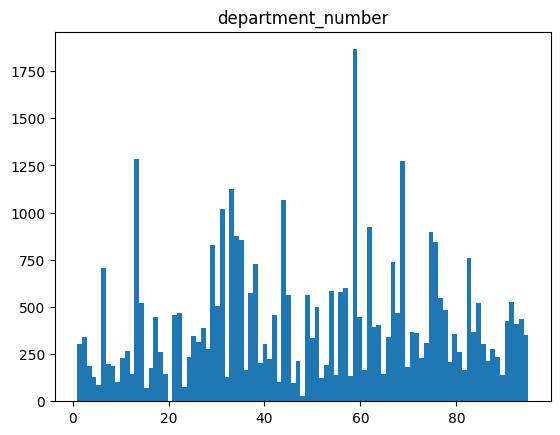

In [86]:
histo(training_tremi, 'age')
histo(training_tremi, 'population')
histo(training_tremi, 'n_development_licence')
histo(training_tremi, 'n_construction_licence')
histo(training_tremi, 'n_destruction_licence')
histo(training_tremi, 'department_number', 95)

# ouput variables

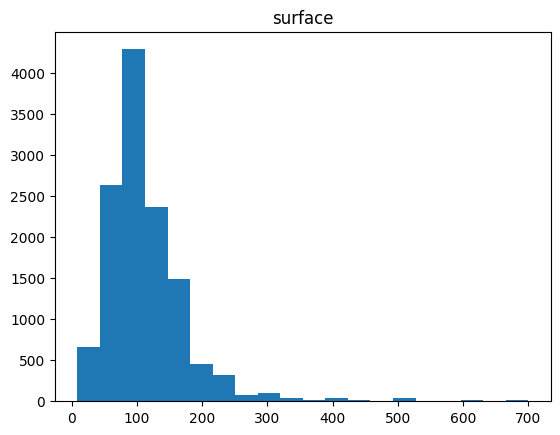

C:\Users\arocheteau\AppData\Local\Temp\ipykernel_23440\4174029921.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%1.2f%%' %i for i in vals])


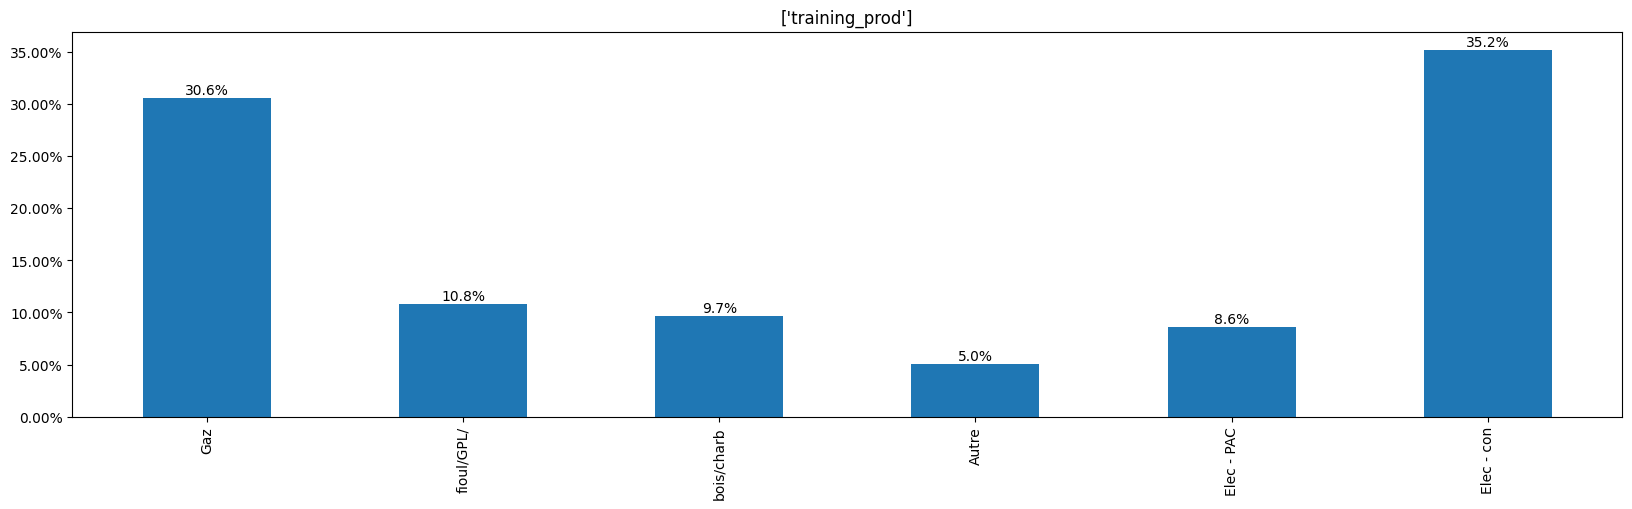

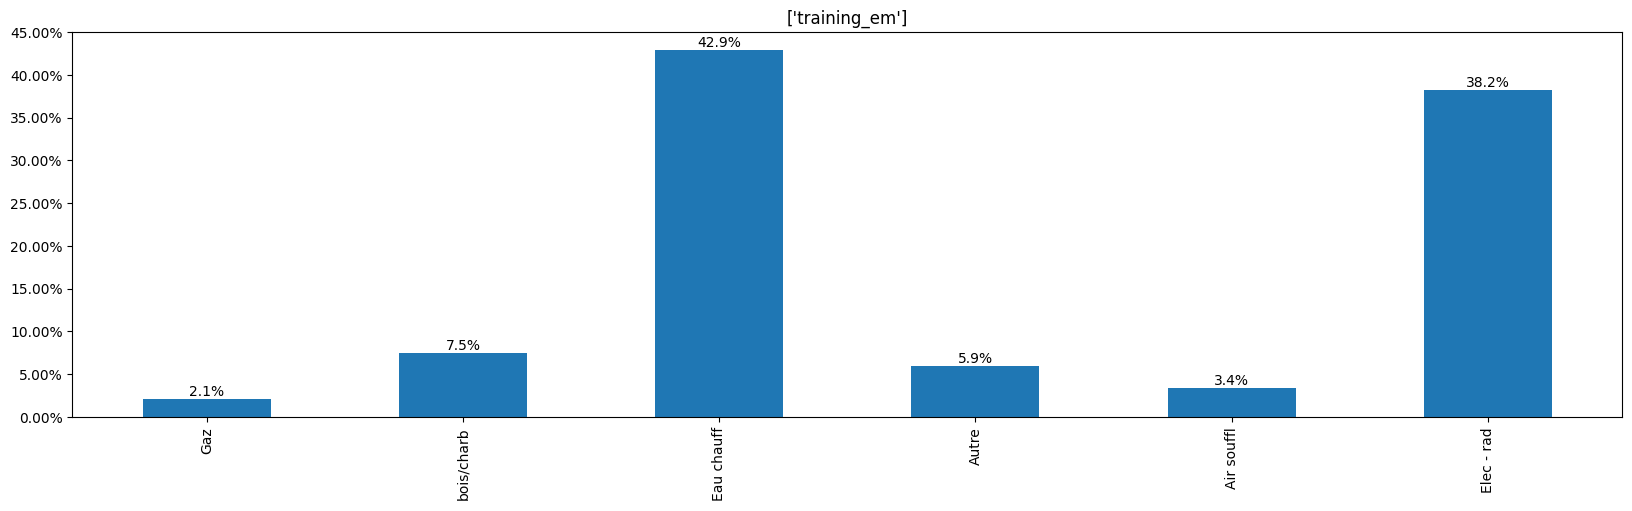

In [87]:
histo(training_surf, 'surface')
compare_repartition([training_prod], 'heating_production')
compare_repartition([training_em], 'heating_emission')

# ML

In [88]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

### surface

In [89]:
X = (
    training_surf.select(
        F.col('gender'),
        F.col('age'),
        F.col('occupation'),
        F.col('home_state'),
        F.col('nb_persons_home'),
        F.col('income'),
        F.col('population'),
        F.col('n_development_licence'),
        F.col('n_construction_licence'),
        F.col('n_new_buildings'),
        F.col('n_destruction_licence'),
        F.col('department_number')
    ).toPandas()
)

y = training_surf.select(F.col('surface')).toPandas()

In [90]:
def least_square(y_true, y_pred):
    return sum([(true[0]-pred[0])**2 for true, pred in zip(y_true, y_pred)])

# calculate number of results inside 15% of real result
def within_percent(y_true, y_pred, percent = 15):
    count = 0
    mult = percent / 100
    for true, pred in zip(y_true, y_pred):
        upper_limit = true[0] * (1 + mult)
        lower_limit = true[0] * (1 - mult)
        if pred[0] < upper_limit and pred[0] > lower_limit:
            count += 1
    return (count / len(y_true)) * 100

In [110]:
# add some non_linearity
poly = PolynomialFeatures(2)
X_transformed = poly.fit_transform(X)
y_transformed = y.to_numpy()

# split training and testing 
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.4, random_state=42)

# linear regression
reg = LinearRegression().fit(X_train, y_train)


In [111]:
# prediction
y_pred = reg.predict(X_test)
print(reg.score(X_test, y_test))

0.1985493800632817


Text(0.5, 0, 'percent around true value')

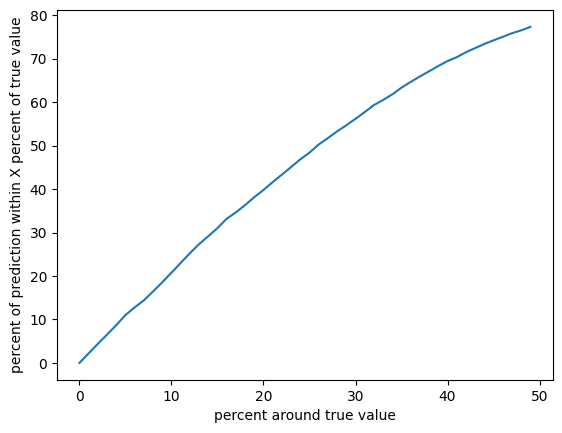

In [112]:
# show within
within = {}
for percent in range(0,50):
    within[percent] = within_percent(y_test, y_pred, percent)
plt.plot(within.keys(), within.values())
plt.ylabel('percent of prediction within X percent of true value')
plt.xlabel('percent around true value')